# Pair trading 策略-考虑时间序列平稳性

In [1]:
import pandas as pd
import numpy as np
import tushare as ts
import seaborn
%matplotlib inline
from matplotlib import pyplot as plt
stocks_pair = ['600199', '600702']

### 前导知识

In [2]:
m = np.array([1,2,3,4,5])
n = m * 5 + 2

In [3]:
n

array([ 7, 12, 17, 22, 27])

In [4]:
slope,intercept  = np.polyfit(m, n ,1).round(2)       #np.polyfit()   unpacked
slope,intercept

(5.0, 2.0)

In [5]:
data1 = ts.get_k_data('600199', '2013-06-01', '2014-12-31')[['date','close']]
data2 = ts.get_k_data('600702', '2013-06-01', '2014-12-31')['close']
data = pd.concat([data1, data2], axis=1)


In [6]:
data.set_index('date',inplace = True)
data.columns = stocks_pair
data.head()

,600199,600702
date,,
2013-06-03,15.505,17.346
2013-06-04,14.880,16.956
2013-06-05,15.043,17.170
2013-06-06,14.668,16.868
2013-06-07,14.245,16.634


In [9]:
data.iloc[:,0]                   #index location,通过索引来获得相关数据,.loc .ix

### 1. 数据准备 & 回测准备

In [ ]:
data1 = ts.get_k_data('600199', '2013-06-01', '2014-12-31')[['date','close']]

In [ ]:
data2 = ts.get_k_data('600702', '2013-06-01', '2014-12-31')['close']

In [ ]:
data = pd.concat([data1, data2], axis=1)

In [ ]:
data.set_index('date',inplace = True)
data.columns = stocks_pair
data.head()

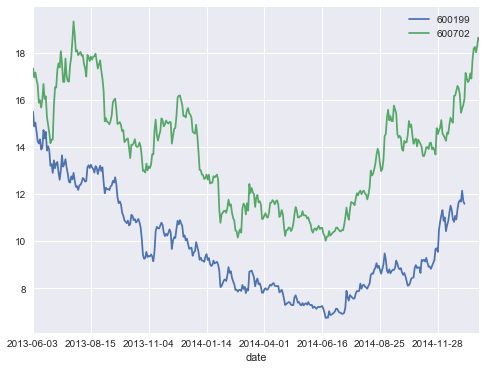

In [10]:
data.plot(figsize= (8,6))

### 2. 策略开发思路

In [11]:
data.corr()                    

,600199,600702
600199,1.000000,0.880779
600702,0.880779,1.000000


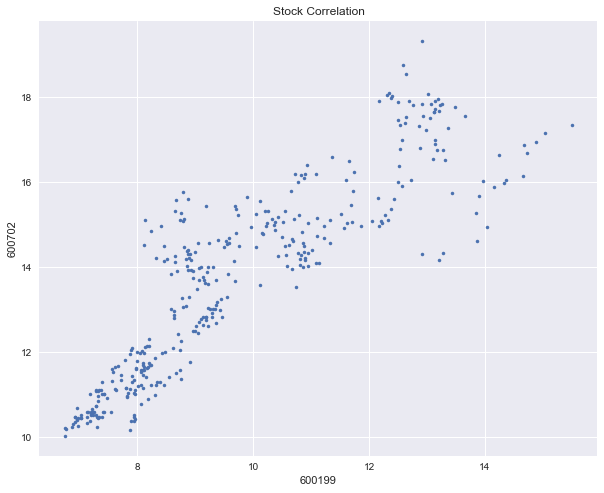

In [12]:
plt.figure(figsize =(10,8))
plt.title('Stock Correlation')
plt.plot(data['600199'], data['600702'], '.')
plt.xlabel('600199')
plt.ylabel('600702')
data.dropna(inplace = True)

In [13]:
[slope, intercept] = np.polyfit(data.iloc[:,0], data.iloc[:,1], 1).round(2)      
slope,intercept

(0.96999999999999997, 4.29)

In [14]:
data['spread'] = data.iloc[:,1] - (data.iloc[:,0]*slope + intercept)

In [15]:
data.head()

,600199,600702,spread
date,,,
2013-06-03,15.505,17.346,-1.98385
2013-06-04,14.880,16.956,-1.76760
2013-06-05,15.043,17.170,-1.71171
2013-06-06,14.668,16.868,-1.64996
2013-06-07,14.245,16.634,-1.47365


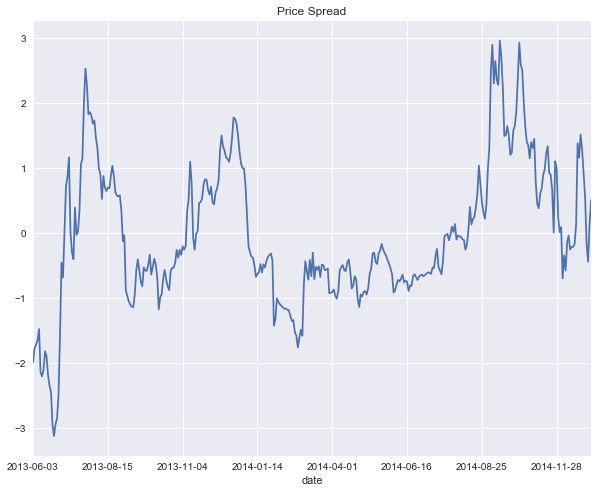

In [16]:
data['spread'].plot(figsize = (10,8),title = 'Price Spread')

In [17]:
data['zscore'] = (data['spread'] - data['spread'].mean())/data['spread'].std()

In [18]:
data.head()

,600199,600702,spread,zscore
date,,,,
2013-06-03,15.505,17.346,-1.98385,-1.804220
2013-06-04,14.880,16.956,-1.76760,-1.604541
2013-06-05,15.043,17.170,-1.71171,-1.552934
2013-06-06,14.668,16.868,-1.64996,-1.495916
2013-06-07,14.245,16.634,-1.47365,-1.333116


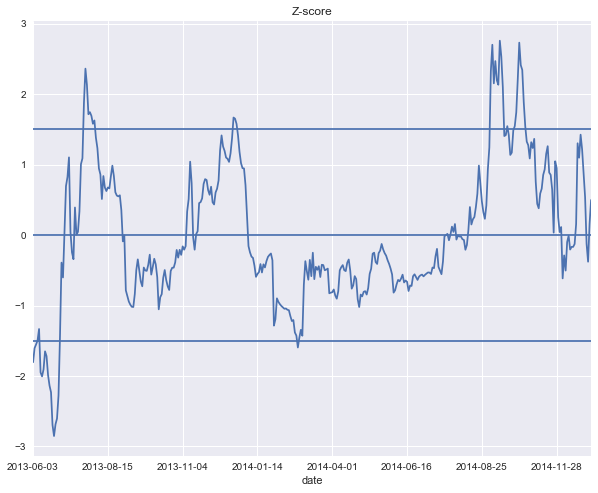

In [19]:
data['zscore'].plot(figsize = (10,8),title = 'Z-score')
plt.axhline(1.5)
plt.axhline(0)
plt.axhline(-1.5)

#### 产生交易信号

In [20]:
data['position_1'] = np.where(data['zscore'] > 1.5, 1, np.nan)
data['position_1'] = np.where(data['zscore'] < -1.5, -1, data['position_1'])
data['position_1'] = np.where(abs(data['zscore']) < 0.5, 0, data['position_1'])

In [21]:
data['position_1'] = data['position_1'].fillna(method = 'ffill')

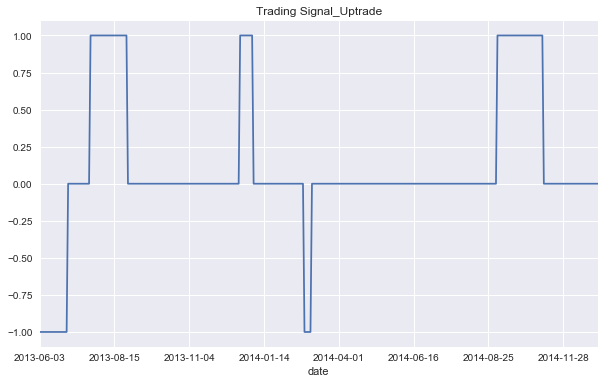

In [22]:
data['position_1'].plot(ylim=[-1.1, 1.1], figsize=(10, 6),title = 'Trading Signal_Uptrade')

In [24]:
data['position_2'] = -np.sign(data['position_1'])

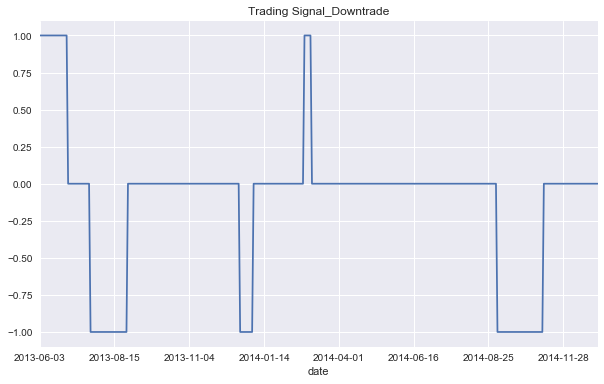

In [25]:
data['position_2'].plot(ylim=[-1.1, 1.1], figsize=(10, 6),title = 'Trading Signal_Downtrade')

### 3. 计算策略年化收益并可视化

In [26]:
data['returns_1'] = np.log(data['600199'] / data['600199'].shift(1))

In [27]:
data['returns_2'] = np.log(data['600702'] / data['600702'].shift(1))

In [28]:
data['strategy'] = 0.5*(data['position_1'].shift(1) * data['returns_1'])
        +0.5*(data['position_2'].shift(1) * data['returns_2'])

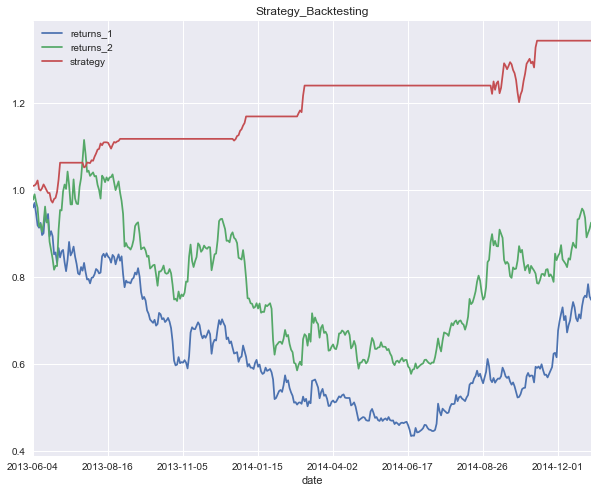

In [29]:
data[['returns_1','returns_2','strategy']].dropna().cumsum().apply(np.exp).
        plot(figsize=(10, 8),title = 'Strategy_Backtesting')

**策略的思考**

1. 对多只ETF进行配对交易，是很多实盘量化基金的交易策略；

**策略的风险和问题：**

1. Spread不回归的风险，当市场结构发生重大改变时，用过去历史回归出来的Spread会发生不回归的重大风险；

2. 中国市场做空受到限制，策略中有部分做空的收益是无法获得的；

3. 回归系数需要Rebalancing；

4. 策略没有考虑交易成本和其他成本；

声明：本资料仅限内部研究和交流使用，切勿外传。